In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
import re
import zipfile

from shapely.geometry import Point

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load in the data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CS229 Final Project/mapdataall.csv')

In [ ]:
df.describe()

,incident_administrative_unit_url,incident_acres_burned,incident_containment,incident_longitude,incident_latitude
count,0.0,2.675000e+03,2669.000000,2.727000e+03,2727.000000
mean,NaN,4.399512e+03,99.856126,-4.370152e+05,39.078546
std,NaN,3.585449e+04,2.943162,2.281499e+07,104.530730
min,NaN,0.000000e+00,0.000000,-1.191415e+09,-120.258000
25%,NaN,3.200000e+01,100.000000,-1.216975e+02,34.681205
50%,NaN,8.600000e+01,100.000000,-1.205089e+02,37.171620
75%,NaN,3.530000e+02,100.000000,-1.184837e+02,39.109005
max,NaN,1.032648e+06,100.000000,1.189082e+02,5487.000000


In [ ]:
df

,incident_name,incident_is_final,incident_date_last_update,incident_date_created,incident_administrative_unit,incident_administrative_unit_url,incident_county,incident_location,incident_acres_burned,incident_containment,...,incident_latitude,incident_type,incident_id,incident_url,incident_date_extinguished,incident_dateonly_extinguished,incident_dateonly_created,is_active,calfire_incident,notification_desired
0,Bridge Fire,Y,2018-01-09T13:46:00Z,2017-10-31T11:22:00Z,Shasta-Trinity National Forest,NaN,Shasta,"I-5 and Turntable Bay, 7 miles NE of Shasta Lake",37.0,100.0,...,40.774000,NaN,2ca11d45-8139-4c16-8af0-880d99b21e82,https://www.fire.ca.gov/incidents/2017/10/31/b...,2018-01-09T13:46:00Z,2018-01-09,2017-10-31,N,False,False
1,Pala Fire,Y,2020-09-16T14:07:35Z,2009-05-24T14:56:00Z,CAL FIRE San Diego Unit,NaN,San Diego,"Hwy 76 and Pala Temecula, northwest of Pala",122.0,100.0,...,1.000000,Wildfire,8f61f461-552d-4538-b186-35ab030da416,https://www.fire.ca.gov/incidents/2009/5/24/pa...,2009-05-25T00:00:00Z,2009-05-25,2009-05-24,N,True,False
2,River Fire,Y,2022-10-24T11:39:23Z,2013-02-24T08:16:00Z,CAL FIRE San Bernardino Unit,NaN,Inyo,"south of Narrow Gauge Rd & north of Hwy 136, e...",407.0,100.0,...,36.602575,NaN,094719ba-a47b-4abb-9ec5-a506b2b9fd23,https://www.fire.ca.gov/incidents/2013/2/24/ri...,2013-02-28T20:00:00Z,2013-02-28,2013-02-24,N,True,False
3,Fawnskin Fire,Y,2013-04-22T09:00:00Z,2013-04-20T17:30:00Z,San Bernardino National Forest,NaN,San Bernardino,"west of Delamar Mountain, north of the communi...",30.0,100.0,...,34.288877,NaN,58f89ff8-bd3e-4355-b1c0-8fa05c747d3f,https://www.fire.ca.gov/incidents/2013/4/20/fa...,2013-04-22T09:00:00Z,2013-04-22,2013-04-20,N,False,False
4,Gold Fire,Y,2013-05-01T07:00:00Z,2013-04-30T12:59:00Z,CAL FIRE Madera-Mariposa-Merced Unit,NaN,Madera,Between Road 210 and Road 200 near Fine Gold C...,274.0,100.0,...,37.116295,NaN,357ffc13-bef9-48eb-810f-c5de851972eb,https://www.fire.ca.gov/incidents/2013/4/30/go...,2013-05-01T07:00:00Z,2013-05-01,2013-04-30,N,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2722,86 Fire,Y,2024-09-28T17:10:26Z,2024-09-27T17:26:28Z,CAL FIRE Riverside Unit,NaN,Riverside,"Highway 86 Expressway / Avenue 70, Thermal",38.0,NaN,...,33.540008,Wildfire,fbc44da8-44a9-47ac-8051-d7aa398df2e5,https://www.fire.ca.gov/incidents/2024/9/27/86...,NaN,NaN,2024-09-27,N,True,False
2723,Chase Fire,Y,2024-09-29T18:55:39Z,2024-09-27T21:10:31Z,NaN,NaN,Kern,"East of Comanche Dr & Breckenridge Rd, Edison",35.0,100.0,...,35.374332,Wildfire,7f988847-1efa-42e3-95b8-b9d736bdddbb,https://www.fire.ca.gov/incidents/2024/9/27/ch...,2024-09-28T08:00:00Z,2024-09-28,2024-09-27,N,False,False
2724,Cindy Fire,Y,2024-09-29T18:55:07Z,2024-09-28T18:12:31Z,NaN,NaN,Los Angeles,"14 Freeway and East Barrel Springs Rd, Palmdale",13.0,100.0,...,34.535270,Wildfire,9a4f6a74-807d-4be5-bb55-c072f7600b83,https://www.fire.ca.gov/incidents/2024/9/28/ci...,2024-09-29T08:00:00Z,2024-09-29,2024-09-28,N,False,False
2725,Ridge Fire,N,2024-09-30T13:06:54Z,2024-09-29T08:30:17Z,Santa Barbara County Fire,NaN,Santa Barbara,"Northeast of Cuarta Road, Hollister Ranch",17.0,30.0,...,34.503340,Wildfire,041dd61f-f516-421e-a295-8bdafe8fb5eb,https://www.fire.ca.gov/incidents/2024/9/29/ri...,NaN,NaN,2024-09-29,Y,False,False


In [ ]:
df.columns

Index(['incident_name', 'incident_is_final', 'incident_date_last_update',
       'incident_date_created', 'incident_administrative_unit',
       'incident_administrative_unit_url', 'incident_county',
       'incident_location', 'incident_acres_burned', 'incident_containment',
       'incident_control', 'incident_cooperating_agencies',
       'incident_longitude', 'incident_latitude', 'incident_type',
       'incident_id', 'incident_url', 'incident_date_extinguished',
       'incident_dateonly_extinguished', 'incident_dateonly_created',
       'is_active', 'calfire_incident', 'notification_desired'],
      dtype='object')

# Preprocess Datetime

In [ ]:
df['incident_date_last_update'] = pd.to_datetime(df['incident_date_last_update'], utc=True)
df['incident_date_created'] = pd.to_datetime(df['incident_date_created'])
df['incident_date_extinguished'] = pd.to_datetime(df['incident_date_extinguished'])
df['incident_year'] = df['incident_date_created'].dt.year
df.drop(['incident_dateonly_extinguished', 'incident_dateonly_created'], axis=1, inplace=True)

# Explore Locations

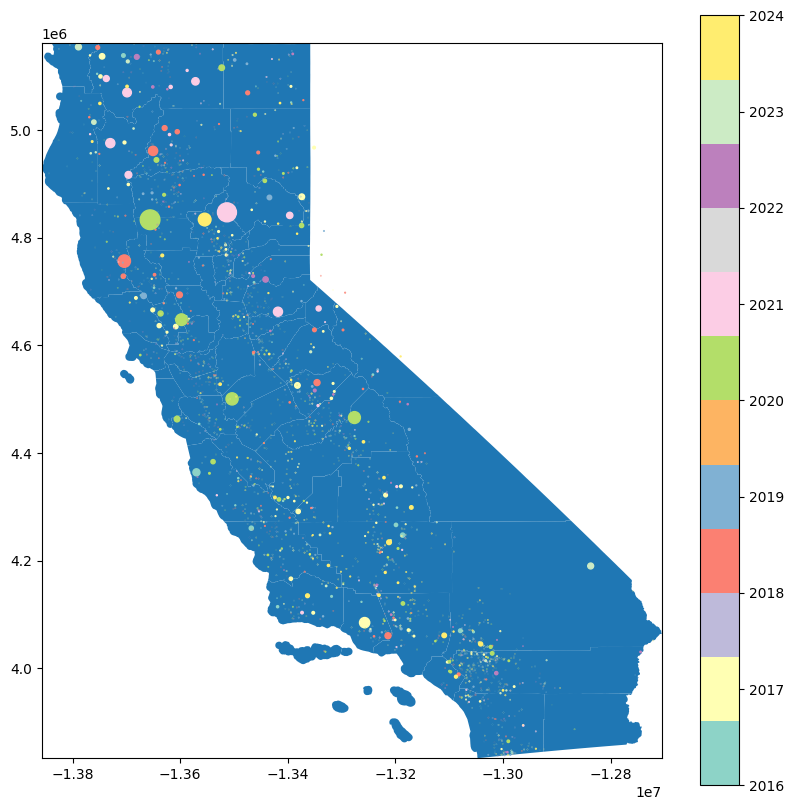

In [ ]:
fp = '/content/drive/MyDrive/CS229 Final Project/CA_Counties.shp'
world = gpd.read_file(fp)
temp= df[(((df['incident_latitude'] > 32) | (df['incident_latitude'] < 42)) & (df['incident_longitude'] < -113) | (df['incident_longitude'] > -125)) & (df['incident_year'] > 2015)]
geometry = [Point(xy) for xy in zip(temp['incident_longitude'], temp['incident_latitude'])]
gdf = gpd.GeoDataFrame(temp,
                       geometry=geometry, crs='epsg:4326')
gdf = gdf.to_crs(world.crs)

ax = world.plot(figsize=(10, 10))
gdf_plot = gdf.plot(ax=ax, column='incident_year', cmap='Set3', s=gdf['incident_acres_burned']/max(gdf['incident_acres_burned'])*200, legend=True)
ax.set_ylim(world.total_bounds[1], world.total_bounds[-1])
ax.set_xlim(world.total_bounds[0], world.total_bounds[2])
plt.show()

In [ ]:
# CA is ~32-42 N and -113- -125
df[((df['incident_latitude'] < 32) | (df['incident_latitude'] > 42)) | (df['incident_longitude'] > -113) | (df['incident_longitude'] < -125)]

,incident_name,incident_is_final,incident_date_last_update,incident_date_created,incident_administrative_unit,incident_administrative_unit_url,incident_county,incident_location,incident_acres_burned,incident_containment,...,incident_longitude,incident_latitude,incident_type,incident_id,incident_url,incident_date_extinguished,is_active,calfire_incident,notification_desired,incident_year
1,Pala Fire,Y,2020-09-16 14:07:35+00:00,2009-05-24 14:56:00+00:00,CAL FIRE San Diego Unit,NaN,San Diego,"Hwy 76 and Pala Temecula, northwest of Pala",122.0,100.0,...,1.000000e+00,1.000000,Wildfire,8f61f461-552d-4538-b186-35ab030da416,https://www.fire.ca.gov/incidents/2009/5/24/pa...,2009-05-25 00:00:00+00:00,N,True,False,2009
167,Norman Fire,Y,2014-06-13 08:00:00+00:00,2014-06-12 14:29:00+00:00,CAL FIRE Sonoma-Lake-Napa Unit,NaN,Solano,"off Rolling Hills Lane, north of Vacaville",70.0,100.0,...,3.845300e+01,121.999000,NaN,45cf54ae-c166-4f81-816f-2e0ef959a56e,https://www.fire.ca.gov/incidents/2014/6/12/no...,2014-06-13 08:00:00+00:00,N,True,False,2014
171,Reed Fire,Y,2014-06-21 19:00:00+00:00,2014-06-20 15:27:00+00:00,CAL FIRE Tuolumne Calaveras Unit,NaN,Calaveras,"off George Reed Drive and Pool Station Road, S...",120.0,100.0,...,3.817824e+01,120.679019,NaN,2b382ade-87e2-4cff-92f7-67328139d7eb,https://www.fire.ca.gov/incidents/2014/6/20/re...,2014-06-21 19:00:00+00:00,N,True,False,2014
191,Oregon Gulch Fire (part of the Beaver Complex),Y,2014-08-18 09:45:00+00:00,2014-07-30 23:00:00+00:00,CAL FIRE Siskiyou Unit / Oregon Dept. of Fores...,NaN,Siskiyou,"Community of Copco, South of Oregon Border",35302.0,100.0,...,-1.223450e+02,42.048000,NaN,3b2609f0-b3a2-493c-bf66-c5b5f64409f8,https://www.fire.ca.gov/incidents/2014/7/30/or...,2014-08-18 09:45:00+00:00,N,True,False,2014
195,Leopard Fire,Y,2014-08-29 13:15:00+00:00,2014-08-29 12:21:00+00:00,CAL FIRE Shasta-Trinity Unit,NaN,Shasta,"Hyrax Road at Dersch Road, east of Redding",25.0,100.0,...,2.924000e+01,40.000000,NaN,952443ab-3af0-431d-9040-c73a45925401,https://www.fire.ca.gov/incidents/2014/8/29/le...,2014-08-29 13:15:00+00:00,N,True,False,2014
196,Pines Fire,Y,2014-12-12 13:45:00+00:00,2014-08-26 16:23:00+00:00,USFS - Sierra National Forest,NaN,Madera,Malum Ridge Road near Bass Lake,10.0,100.0,...,1.840000e+01,37.000000,NaN,a2da7754-e907-48f2-a023-0a3053cf2903,https://www.fire.ca.gov/incidents/2014/8/26/pi...,2014-12-12 13:45:00+00:00,N,True,False,2014
210,Dog Rock Fire,Y,2014-10-12 18:00:00+00:00,2014-10-07 15:05:00+00:00,Yosemite National Park,NaN,Mariposa,"Hwy 140 at Indian Creek, El Portal Community",311.0,100.0,...,4.034000e+01,37.000000,NaN,ba17d495-8ce6-4a0f-a3ba-487bd877969e,https://www.fire.ca.gov/incidents/2014/10/7/do...,2014-10-12 18:00:00+00:00,N,False,False,2014
300,Elk Fire,Y,2015-09-08 19:28:00+00:00,2015-09-02 14:57:00+00:00,CAL FIRE Sonoma-Lake-Napa Unit / Mendocino Nat...,NaN,Lake,Off of Elk Mountain Road and Mount Dinger Road...,673.0,100.0,...,-1.220000e+02,55.230000,NaN,0eed7005-6ace-4eb2-8919-eb131c246f84,https://www.fire.ca.gov/incidents/2015/9/2/elk...,2015-09-08 19:28:00+00:00,N,True,False,2015
301,Olive Fire,Y,2015-09-03 19:35:00+00:00,2015-09-02 13:18:00+00:00,CAL FIRE Butte Unit,NaN,Butte,"Off of Olive Tree Lane, south of Oroville",72.0,100.0,...,-1.210000e+02,26.420000,NaN,3435fd06-f77e-42c3-8fa5-261cf0cb828c,https://www.fire.ca.gov/incidents/2015/9/2/oli...,2015-09-03 19:35:00+00:00,N,True,False,2015
304,Browns Fire,Y,2015-09-10 17:05:00+00:00,2015-09-08 15:56:00+00:00,CAL FIRE Shasta-Trinity Unit,NaN,Trinity,Hwy 299 and Little Browns Creek Rd east of Wea...,35.0,100.0,...,4.146000e+01,40.000000,NaN,5046e2ed-e2c3-4932-8f89-64dcdf19022d,https://www.fire.ca.gov/incidents/2015/9/8/bro...,2015-09-10 17:05:00+00:00,N,True,False,2015


# Explore Control + Units

In [ ]:
df['incident_administrative_unit'].describe()

,incident_administrative_unit
count,2677
unique,768
top,CAL FIRE Santa Clara Unit
freq,109


In [ ]:
px.bar(df.groupby('incident_administrative_unit').count()['incident_name'])

In [ ]:
df['incident_cooperating_agencies'].describe()

,incident_cooperating_agencies
count,1644
unique,754
top,CAL FIRE Santa Clara Unit
freq,55


In [ ]:
df['incident_num_agencies'] = [np.nan]*len(df)
for i, string in enumerate(df['incident_cooperating_agencies']):
  if pd.notna(string):
    agencies = re.split('[,/]', string)
    df.loc[i, 'incident_num_agencies'] = len(agencies)
df['incident_num_agencies'].describe()


,incident_num_agencies
count,1644.000000
mean,2.672749
std,4.380276
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,62.000000


In [ ]:
px.scatter(df, y=df['incident_acres_burned'], x=df['incident_num_agencies'], color=df['incident_year'].astype(str))

In [2]:
folders = "/content/drive/MyDrive/CS229 Final Project/Weather Data (Almanac)/"
for folder in os.listdir(folders):
  with zipfile.ZipFile(folders+folder, 'r') as zip_ref:
    zip_ref.extractall(folders)
    if not os.path.exists(folders + " Archive/"):
        os.makedirs(folders + " Archive/")
    shutil.copy(folders + folder, folders + "Archive/")
    os.remove(folders + folder)

locations = []
for folder in os.listdir(folders):
  locations.append(folder.split('_')[1])
  with zipfile.ZipFile(folders+folder, 'r') as zip_ref:
    zip_ref.extractall(folders)
    shutil.move(folder, folders + "Archive")
for folder in os.listdir(folders):
  print(folder)



NameError: name 'os' is not defined